In [1]:
import numpy as np
import pandas as pd
import pickle
from xgboost import XGBRegressor
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

In [2]:
train_data = np.load('train_data.npy', allow_pickle=True)
train_data = train_data.item()

In [3]:
df_train_label = pd.read_csv('y_train.csv')
df_test_label = pd.read_csv('y_test.csv')

In [4]:
X = []
y = []

for id_, chunks in train_data.items():
    age = df_train_label.loc[df_train_label['id'] == id_, 'age'].values[0]
    for chunk in chunks:
        X.append(chunk.flatten())
        y.append(age)

X = np.array(X)
y = np.array(y)

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def perform_pca(data, variance_threshold=0.95):
	"""
	Perform PCA on input data with options for choosing number of components.
	
	Parameters:
	-----------
	data : numpy.ndarray
		Input data of shape (n_samples, n_features)
	variance_threshold : float, optional
		Minimum fraction of variance to retain when n_components is None
		
	Returns:
	--------
	transformed_data : numpy.ndarray
		PCA transformed data
	pca : sklearn.decomposition.PCA
		Fitted PCA object
	explained_variance_ratio : numpy.ndarray
		Ratio of variance explained by each component
	"""

	scaler = StandardScaler()
	scaled_data = scaler.fit_transform(data)
	
	# Initially fit PCA with all components
	temp_pca = PCA()
	temp_pca.fit(scaled_data)
	
	# Find number of components needed to explain variance_threshold of variance
	cumulative_variance_ratio = np.cumsum(temp_pca.explained_variance_ratio_)
	n_components = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1
	
	# Perform PCA with determined number of components
	pca = PCA(n_components=n_components)
	transformed_data = pca.fit_transform(scaled_data)
	
	return transformed_data, pca, pca.explained_variance_ratio_

In [6]:
data = X

transformed_data, pca_model, variance_ratio = perform_pca(data, variance_threshold=0.95)

print(f"Number of components needed for 95% variance: {transformed_data.shape[1]}")
print(f"Total variance explained: {sum(variance_ratio):.3f}")
X = transformed_data

Number of components needed for 95% variance: 463
Total variance explained: 0.949


In [7]:
# shuffle data
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

### Train all data

In [8]:
# train_all_data = np.load('train_all_data.npy', allow_pickle=True)
# train_all_data.shape

In [9]:
# X_train_all = []
# y_train_all = []

# for i in range(120):
#     X_train_all.append(train_all_data[i].flatten())
#     y_train_all.append(df_train_label.iloc[i]['age'])

# X_train_all = np.array(X_train_all)
# y_train_all = np.array(y_train_all)

In [10]:
# data = X_train_all

# # Method 2: Use variance threshold
# transformed_data, pca_model, variance_ratio = perform_pca(data, variance_threshold=0.95)

# print(f"Number of components needed for 95% variance: {transformed_data.shape[1]}")
# print(f"Total variance explained: {sum(variance_ratio):.3f}")

In [11]:
# X_train_all = transformed_data

# Regressor

In [12]:
# from sklearn.model_selection import GridSearchCV, KFold

# param_grid = {
#     'n_estimators': [500],
#     'learning_rate': [0.05],
#     'max_depth': [5],
#     'min_child_weight': [5],
#     'gamma': [1],
#     'colsample_bytree': [0.7],
#     'subsample': [0.7],
#     'reg_alpha': [0.5],
#     'reg_lambda': [1.0]
# }

# kfold = KFold(n_splits=5, shuffle=True, random_state=4269)
# grid_search = GridSearchCV(
#     estimator=XGBRegressor(objective='reg:absoluteerror'),
#     param_grid=param_grid,
#     cv=kfold,
#     scoring='neg_mean_absolute_error',
#     n_jobs=-1,
#     verbose=2
# )

# grid_search.fit(X, y)
# print("Best parameters:", grid_search.best_params_)

In [13]:
regressor = XGBRegressor(
    objective='reg:absoluteerror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=5,
    gamma=1,
    colsample_bytree=0.7,
    subsample=0.7,
    reg_alpha=0.5,
    reg_lambda=1.0
)

regressor.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [14]:
# # Rank features by importance
# feature_importances = regressor.feature_importances_
# # Plot
# import matplotlib.pyplot as plt
# plt.figure(figsize=(15, 5))
# plt.title("Feature importances")
# # plt.bar(range(X.shape[1]), indices)
# # There are 520 features, plot each 10 features as a group
# for i in range(0, X.shape[1], 10):
# 	plt.bar(range(i, i + 10), feature_importances[i:i + 10])
# plt.show()

In [15]:
# # Save the model
# pickle.dump(regressor, open('model.pkl', 'wb'))

In [16]:
# # Load the model
# regressor = pickle.load(open('model.pkl', 'rb'))

In [17]:
test_data = np.load('test_features.npy', allow_pickle=True)
test_data.shape

(40, 52, 20)

In [18]:
X_test = []
Y_test = []

for i in range(40):
	X_test.append(test_data[i].flatten())
	Y_test.append(df_test_label.iloc[i]['age'])

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [19]:
X_test_pca = pca_model.transform(X_test)

In [20]:
# test_chunk = np.load('test_data.npy', allow_pickle=True)
# test_chunk = test_chunk.item()

In [21]:
# X_test_chunk = []
# y_test_chunk = []

# for id_, chunks in test_chunk.items():
#     age = df_test_label.loc[df_test_label['id'] == id_, 'age'].values[0]
#     for chunk in chunks:
#         X_test_chunk.append(chunk.flatten())
#         y_test_chunk.append(age)

# X_test_chunk = np.array(X_test_chunk)
# y_test_chunk = np.array(y_test_chunk)

In [22]:
# X_test_chunk_pca = pca_model.transform(X_test_chunk)

In [23]:
# Predict
y_pred = regressor.predict(X_test_pca)
# Calculate MAE
mae = mean_absolute_error(Y_test, y_pred)
print('MAE:', mae)

MAE: 20.088748264312745


In [24]:
print('Predicted:', y_pred)
print('True:', Y_test)

Predicted: [61.876392 62.09893  66.50735  62.348663 62.084984 66.17364  59.246918
 61.93766  63.099525 60.213547 61.98111  58.561966 56.801216 62.619614
 50.07598  62.74624  53.888626 61.631107 54.975544 63.921875 58.12164
 63.776306 63.654526 61.771217 61.858936 49.93161  62.78086  64.09162
 63.152477 58.450615 65.14753  65.31234  56.702656 62.70713  62.768246
 67.490204 55.048172 61.816986 53.021866 57.466633]
True: [22 23 25 29 25 24 18 26 31 31 33 36 35 42 44 40 44 39 49 57 57 48 52 53
 62 66 67 62 66 70 77 75 69 77 81 85 78 87 82 86]


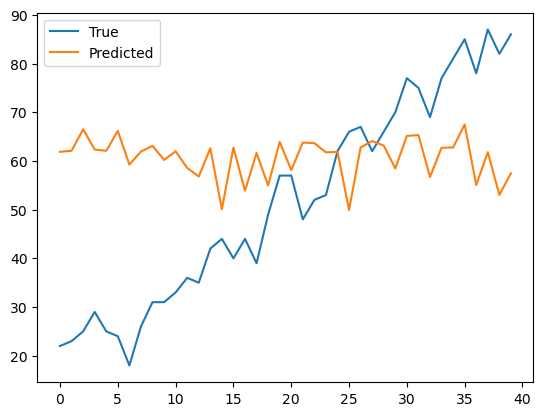

In [25]:
# Plot the prediction as a line graph
import matplotlib.pyplot as plt
plt.plot(Y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()